<a href="https://colab.research.google.com/github/siddish-reddy/KSP-IPH-2019-Table25-Legion-FR/blob/master/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from facenet_pytorch import MTCNN, InceptionResnetV1

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from scipy.spatial import distance
from PIL import Image

workers = 0 if os.name == 'nt' else 4

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [0]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, prewhiten=True )

In [0]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [0]:
def return_first(x):
    return x[0]

dataset = datasets.ImageFolder('iph2019')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=return_first, num_workers=workers)

In [0]:
len(dataset)

In [0]:
dataset[0]

In [0]:
dataset.idx_to_class[0]

In [0]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        #print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

In [0]:
len(aligned)

In [0]:
aligned[:2]

In [0]:
aligned = torch.stack(aligned).to(device)

In [0]:
len(aligned)

In [0]:
embeddings = torch.tensor([])
start = 0
stop = len(aligned)//10
step = stop
while stop<len(aligned):
  print("processing:", start, stop)
  temp = resnet(aligned[start:stop]).detach().cpu()
  start = stop
  stop = stop+step
  embeddings = torch.cat((embeddings, temp))
embeddings = torch.cat((embeddings,resnet(aligned[start:]).detach().cpu()))
print(len(embeddings))
em_df = pd.DataFrame(s, columns=[i for i in range(s[0].shape[0])], index=names)
em_df.to_csv('embeddings.csv')

## Run for testing from here

In [0]:
missing_df = pd.read_csv('/content/drive/My Drive/iph2019/embeddings/miss.csv', index_col=0)
unnat_df = pd.read_csv('/content/drive/My Drive/iph2019/embeddings/unnat.csv',index_col=0)
arrest_df = pd.read_csv('/content/drive/My Drive/iph2019/embeddings/arrest.csv',index_col=0)
wanted_df = pd.read_csv('/content/drive/My Drive/iph2019/embeddings/want.csv',index_col=0)

In [0]:
common_df = pd.concat([missing_df,unnat_df,arrest_df,wanted_df],axis = 0)
common_df.shape

(4217, 512)

In [0]:
embeds = common_df.to_numpy()

In [0]:
arrest_embeds =  arrest_df.to_numpy()
unnat_embeds = unnat_df.to_numpy()
missing_embeds = missing_df.to_numpy()
wanted_embeds = wanted_df.to_numpy()

In [0]:
from scipy.spatial import distance

In [0]:
euc_dists = [[distance.euclidean(e1 , e2) for e2 in embeds] for e1 in embeds]
euc_df = pd.DataFrame(euc_dists, columns=common_df.index, index=common_df.index)
euc_df.shape

In [0]:
euc_df.to_csv('/content/drive/My Drive/iph2019/embeddings/euclidean.csv')

In [0]:
cos_dists = [[distance.cosine(e1 , e2) for e2 in embeds] for e1 in embeds]
cos_df = pd.DataFrame(cos_dists, columns=common_df.index, index=common_df.index)
cos_df.shape

(4217, 4217)

In [0]:
cos_df.to_csv('/content/drive/My Drive/iph2019/embeddings/cosine.csv')

In [0]:
best_files = []
least_losses = []
euc_np = euc_df.to_numpy()
cos_np = cos_df.to_numpy()
for i in range(len(euc_np)):
  losses = (euc_np[i]+cos_np[i])/2
  x,y=0,0
  min1,min2 = 10,10
  for l,loss in enumerate(losses):
    if loss != 0 and loss<min1:
      min1=loss
      x=l
    elif loss!=0 and loss<min2:
      min2=loss
      y=l
  print(i, end='\n') if i%100 ==0 else print('.', end='')
  c1 = euc_df.index[x]
  best_files.append([euc_df.index[x],euc_df.index[y]])
  least_losses.append([min1,min2])
    

0
...................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
.......................................................................

In [0]:
best_matched = []
for i, loss in enumerate( least_losses):
  for l in loss:
    if l<0.5:
      best_matched.append(i)

In [0]:
len(best_matched)

929

In [0]:
print(best_matched)

[414, 483, 551, 685, 998, 1096, 1149, 1579, 1624, 2051, 2196, 2196, 2247, 2247, 2349, 2459, 2546, 2558, 2849, 2909, 3318, 3459, 3478, 3711, 3714, 3984, 3985]


In [0]:
plots=[]
for match in best_matched:
  plots.append([euc_df.index[match], best_files[match][0],best_files[match][1]])

In [0]:
missing = []
for i in range(len(plots)):
  c1 = plots[i][0].split('/')[5]
  c2 = plots[i][1].split('/')[5]
  c3 = plots[i][2].split('/')[5]
  if c1 == 'missing_images' and c1!=c2:
    missing.append(plots[i])

len(missing)

12

In [0]:
unnat = []
for i in range(len(plots)):
  c1 = plots[i][0].split('/')[5]
  c2 = plots[i][1].split('/')[5]
  c3 = plots[i][2].split('/')[5]
  if c1 == 'unnatural_death_images' and c1!=c2 and 'Koala' not in plots[i][1]:
    unnat.append(plots[i])
len(unnat)

8

In [0]:
arrest = []
for i in range(len(plots)):
  c1 = plots[i][0].split('/')[5]
  c2 = plots[i][1].split('/')[5]
  c3 = plots[i][2].split('/')[5]
  if c1 == 'arrest' and c1!=c2:
    arrest.append(plots[i])
len(arrest)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
def plot(files_array):
  fig, axs = plt.subplots(len(files_array),2, figsize = (8, len(files_array)*2.6))
  for i in range(len(files_array)):
    for j in range(2):
      axs[i,j].imshow(mpimg.imread(files_array[i][j]))
      axs[i,j].set_title(files_array[i][j][32:35]+files_array[i][j][50:55])
  plt.show()


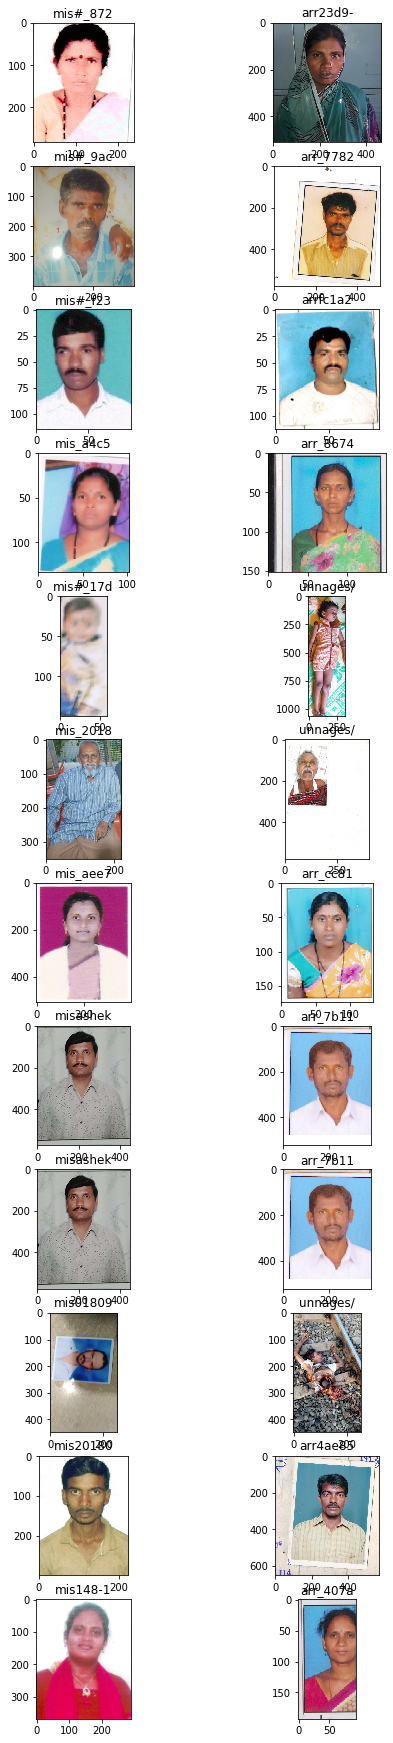

In [0]:
plot(missing)

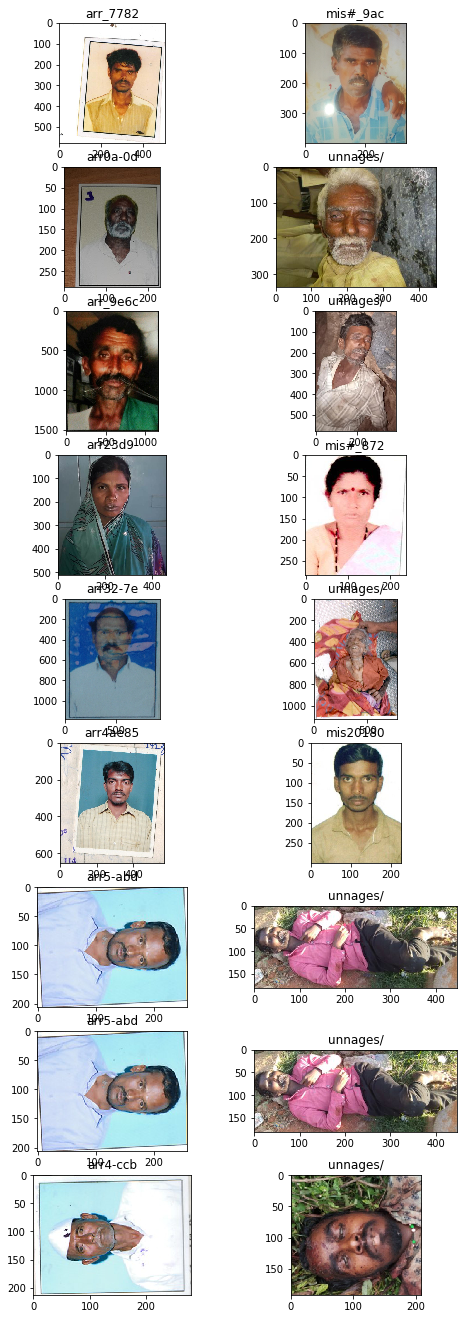

In [0]:
plot(arrest)

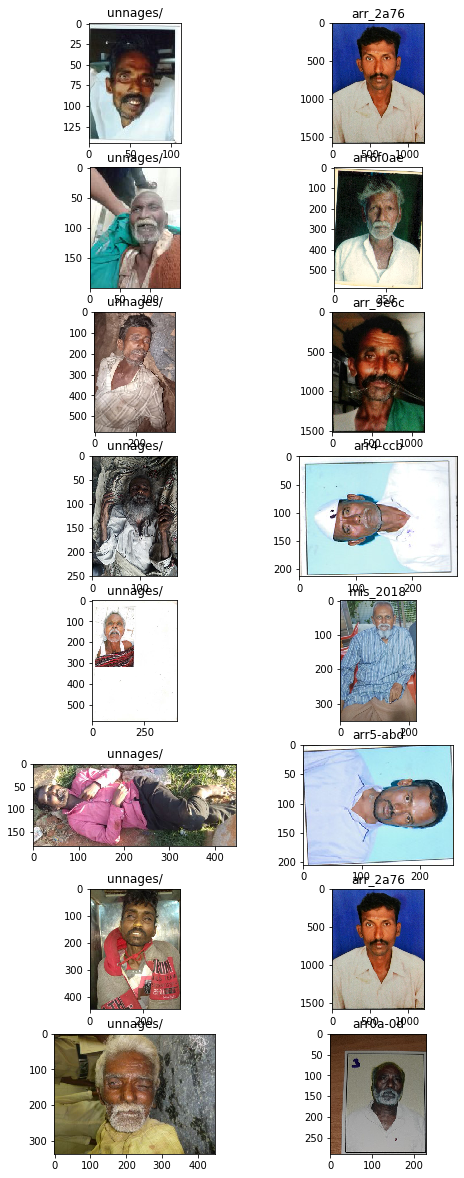

In [0]:
plot(unnat)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Metric testings

[link text](https://)

In [0]:
testss = ['dean1.jpeg', 'dean2.jpeg', 'dean3.jpg', 'rudra.jpg', 'rudra1.jpeg', 'rudra2.jpeg', 'sid1.jpg', 'sid2.jpg', 'sid3.jpg']
ems = torch.tensor([])
for t in testss:
  f = tuple(mtcnn(Image.open(t)))
  f = torch.stack(f).to(device)
  ems = torch.cat((ems, resnet(f.unsqueeze(0)).detach().cpu()))
len(ems)

In [0]:
euc_dist = [[distance.euclidean(e1 , e2) for e2 in ems] for e1 in ems]
pd.DataFrame(dists, columns=testss, index=testss)

In [0]:
cos_dist = [[distance.cosine(e1 , e2) for e2 in ems] for e1 in ems]
pd.DataFrame(dists, columns=testss, index=testss)

In [0]:
def image_to_encoding(path):
  im = Image.open(path)
  try:
    x, _ = mtcnn(im, return_prob = True) 
  except RuntimeError:
    x, _ = mtcnn(im.convert('RGB'), return_prob = True) 
  if (x) is not (None):
    face_tensor = tuple(x)
    face_tensor = torch.stack(face_tensor).to(device)
    embedding = resnet(face_tensor.unsqueeze(0)).detach().cpu()
  return embedding

In [0]:
def files_to_embeddings(path, save_to_csv):
  files = []
  IMG_EXTENSIONS = [ '.jpg', '.JPG', '.jpeg', '.JPEG','.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']
  for ext in IMG_EXTENSIONS:
    files +=  glob.glob(path+'/*'+ext)
  print('found:{} total image files'.format(len(files)))
  ems = torch.tensor([])
  res_files = []
  print("--------Started--------")
  for i, t in enumerate(files):
    im = Image.open(t)
    try:
      x, _ = mtcnn(im, return_prob = True) 
    except RuntimeError:
      x, _ = mtcnn(im.convert('RGB'), return_prob = True) 
    try: 
      if (x) is not (None):
        face_tensors = tuple(x)
        face_tensors_batch = torch.stack(face_tensors).to(device)
        ems = torch.cat((ems, resnet(face_tensors_batch.unsqueeze(0)).detach().cpu()))
        res_files.append(files[i])
    except e:
        print(e,i,files[i])
    
    print(i,end='\n') if i%100 ==0 else print(".",end="")
  
  print("found {} faces".format(len(ems)))
  ems = ems.cpu().numpy()
  if save_to_csv:
    em_df = pd.DataFrame(ems, columns=[i for i in range(ems[0].shape[0])], index=res_files)
    print('saving into csv: '+save_to_csv)
    em_df.to_csv(save_to_csv)
  return ems

In [0]:
files = []
IMG_EXTENSIONS = [ '.jpg', '.JPG', '.jpeg', '.JPEG','.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']
for ext in IMG_EXTENSIONS:
  files +=  glob.glob(path1+'/*'+ext)

In [0]:
files[3921]

'/content/drive/My Drive/iph2019/unnatural_death_images/UDR NO 07-#_ba6a4914-ffd6-4d20-b8b9-9eda1f42a7e91072.png'

In [0]:
image_to_encoding(files[3921])

tensor([[ 1.3450e-02, -1.1883e-02, -3.2727e-02, -2.3898e-02,  2.3325e-02,
          4.8682e-02, -8.4093e-03,  4.7841e-02, -8.7435e-03,  4.4753e-02,
         -9.1310e-03,  1.5316e-02,  4.5355e-02, -2.5434e-02, -5.9102e-02,
          2.9704e-02, -5.2355e-02, -1.4875e-03,  8.7336e-03, -2.3118e-02,
         -5.3403e-02,  5.6027e-02,  6.4576e-03, -3.6858e-02,  2.0942e-02,
          4.9054e-02, -2.8539e-02, -7.5157e-02,  2.2123e-02, -4.1683e-02,
         -2.5420e-02,  3.2883e-02,  2.9407e-02,  5.0056e-02, -2.7311e-03,
          6.5438e-05,  1.7500e-02, -4.4046e-02, -2.1236e-02,  4.8614e-02,
          8.0159e-03,  4.6101e-03,  4.2981e-02,  7.0266e-02, -5.1228e-02,
          5.6214e-02, -4.9363e-02,  8.6153e-02, -8.3971e-02,  1.2519e-02,
         -8.8415e-03, -1.6295e-02,  2.9906e-02,  4.6392e-03,  1.8212e-03,
          6.1222e-02,  6.0907e-02, -5.2597e-02, -5.8677e-02, -6.2319e-02,
          2.6606e-02,  9.5570e-02, -7.6624e-02, -5.3747e-02, -5.4584e-02,
         -3.9207e-02, -5.6280e-02,  9.

In [0]:
path = '/content/drive/My Drive/iph2019/arrest'

In [0]:
path1 = '/content/drive/My Drive/iph2019/unnatural_death_images'

In [0]:
save_csv_un = 'unnatural_death.csv'

In [0]:
save_csv ='arrest.csv'

In [0]:
res_arrest = files_to_embeddings(path,save_csv)

found:974 total image files
--------Started--------
0
...................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
...................

In [0]:
res_unnatural = files_to_embeddings(path1,save_csv_un)

found:3936 total image files
--------Started--------
0
...................................................................................................100
...................................................................................................200
...................................................................................................300
...................................................................................................400
...................................................................................................500
...................................................................................................600
...................................................................................................700
...................................................................................................800
...................................................................................................900
..................

In [0]:
missing_path = '/content/drive/My Drive/iph2019/missing_images'

In [0]:
missing_save_csv = 'missing_csv.csv'

In [0]:
res_miss = files_to_embeddings(missing_path,missing_save_csv)

found:960 total image files
--------Started--------
0
...................................................

KeyboardInterrupt: ignored